In [2]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
import keras._tf_keras.keras
from keras._tf_keras.keras import backend as K
from keras._tf_keras.keras.callbacks import Callback,ModelCheckpoint
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
import seaborn as sns
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

In [30]:
@dataclass
class G:
    n_classes = 4
    IMAGE_ORDERING = 'channels_last'

In [4]:
path = os.path.join(os.getcwd(),'data')
train = pd.read_csv(path + '/train.csv')
test = os.path.join(os.getcwd(),'data/test_images')

In [5]:
train2 = train.pivot(index='ImageId', columns='ClassId', 
                     values='EncodedPixels')
train2.fillna('',inplace=True); 
train2['count'] = np.sum(train2.iloc[:]!='',axis=1).values
train2 = pd.DataFrame(train2.to_records())
train2.rename(columns={"1":"e1","2":"e2","3":"e3","4":"e4"}, inplace=True)
train2.head()

ImageId                                                 e1 e2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...      
1  0007a71bf.jpg                                                         
2  000a4bcdd.jpg  37607 3 37858 8 38108 14 38359 20 38610 25 388...      
3  000f6bf48.jpg                                                         
4  0014fce06.jpg                                                         

                                                  e3  \
0                                                      
1  18661 28 18863 82 19091 110 19347 110 19603 11...   
2                                                      
3                                                      
4  229501 11 229741 33 229981 55 230221 77 230468...   

                                                  e4  count  
0                                                         1  
1                                                         1  
2                                                         1  
3  131973 1 132228 4 132483 6 132738 8 132993 11 ...      1  
4                                                         1

### Utility Function

In [6]:
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask

In [45]:
# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# parameter describing where the channel dimension is found in our dataset


def conv_block(input, filters, strides = 2, pooling_size = 2, pool_strides = 2):
  '''
  Args:
    input (tensor) -- batch of images or features
    filters (int) -- number of filters of the Conv2D layers
    strides (int) -- strides setting of the Conv2D layers
    pooling_size (int) -- pooling size of the MaxPooling2D layers
    pool_strides (int) -- strides setting of the MaxPooling2D layers
  
  Returns:
    (tensor) max pooled and batch-normalized features of the input 
  '''
  ### START CODE HERE ###
  # use the functional syntax to stack the layers as shown in the diagram above
  x = keras.layers.Conv2D(filters, strides, padding='same', 
                          data_format=G.IMAGE_ORDERING)(input)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.Conv2D(filters, strides, padding='same', 
                          data_format=G.IMAGE_ORDERING)(x)
  x = keras.layers.LeakyReLU()(x)
  x = keras.layers.MaxPooling2D(pool_size=pooling_size, strides=pool_strides)(x)
  x = keras.layers.BatchNormalization()(x)
  ### END CODE HERE ###

  return x


# Define the Downsampling Path
def FCN8(input_height=128, input_width=800):
    '''
    Defines the downsampling path of the image segmentation model.

    Args:
      input_height (int) -- height of the images
      width (int) -- width of the images

    Returns:
    (tuple of tensors, tensor)
      tuple of tensors -- features extracted at blocks 3 to 5
      tensor -- copy of the input
    '''
   
    img_input = keras.layers.Input(shape=(input_height,input_width,3))

    ### START CODE HERE ###
    
    # pad the input image to have dimensions to the nearest power of two
    x = keras.layers.ZeroPadding2D(padding=(0, 6))(img_input)

    # Block 1
    x = conv_block(x, 32)
    
    # Block 2
    x = conv_block(x, 64)

    # Block 3
    x = conv_block(x, 128)
    # save the feature map at this stage
    f3 = x

    # Block 4
    x = conv_block(x, 256)
    # save the feature map at this stage
    f4 = x

    # Block 5
    x = conv_block(x, 256)
    # save the feature map at this stage
    f5 = x

    ### END CODE HERE ###
  
    return (f3, f4, f5), img_input

# Define the FCN-8 decoder
def fcn8_decoder(convs, n_classes):
  # features from the encoder stage
  f3, f4, f5 = convs

  # number of filters
  n = 512

  # add convolutional layers on top of the CNN extractor.
  o = keras.layers.Conv2D(n , (7 , 7) , activation='relu' , padding='same', 
                          name="conv6", data_format=G.IMAGE_ORDERING)(f5)
  o = keras.layers.Dropout(0.5)(o)

  o = keras.layers.Conv2D(n , (1 , 1) , activation='relu' , padding='same', 
                          name="conv7", data_format=G.IMAGE_ORDERING)(o)
  o = keras.layers.Dropout(0.5)(o)

  o = keras.layers.Conv2D(n_classes,  (1, 1), activation='relu' , 
                          padding='same', data_format=G.IMAGE_ORDERING)(o)


  ### START CODE HERE ###

  # Upsample `o` above and crop any extra pixels introduced
  o = keras.layers.Conv2DTranspose(n_classes, kernel_size = (4,4), strides = (2,2))(f5)
  o = keras.layers.Cropping2D(cropping = (1,1))(o)

  # load the pool 4 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f4
  o2 = keras.layers.Conv2D(n_classes, kernel_size=(1,1), activation='relu', 
                           padding='same', data_format=G.IMAGE_ORDERING)(o2)

  # add the results of the upsampling and pool 4 prediction
  o = keras.layers.Add()([o,o2])

  # upsample the resulting tensor of the operation you just did
  o = keras.layers.Conv2DTranspose(n_classes, kernel_size=(4,4), strides = (2,2))(o)
  o = keras.layers.Cropping2D(cropping = (1,1))(o)

  # load the pool 3 prediction and do a 1x1 convolution to reshape it to the same shape of `o` above
  o2 = f3
  o2 = keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , 
                           padding='same', data_format=G.IMAGE_ORDERING)(o2)

  # add the results of the upsampling and pool 3 prediction
  o = keras.layers.Add()([o, o2])

  # upsample up to the size of the original image
  o = keras.layers.Conv2DTranspose(n_classes, kernel_size=(8,8), strides = (8,8))(o)
  o = keras.layers.Cropping2D(((0, 0), (0, 96-84)))(o)

  # append a sigmoid activation
  o = (keras.layers.Activation('softmax'))(o)
  ### END CODE HERE ###

  return o

### Data Generator

In [8]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        self.on_epoch_end()
        
        if self.subset == "train":
            self.data_path = path + '/train_images/'
        elif self.subset == "test":
            self.data_path = path + '/test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

### Train EDA

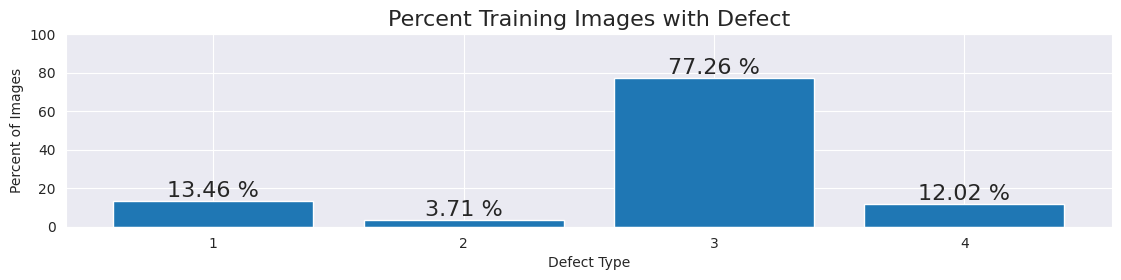

In [9]:
plt.figure(figsize=(13.5,2.5))
bar = plt.bar( [1,2,3,4],100*np.mean( train2.iloc[:,1:5]!='',axis=0))
plt.title('Percent Training Images with Defect', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Defect Type')
plt.xticks([1,2,3,4])
for rect in bar:    
    height = rect.get_height()    
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.2f %%' % height,
             ha='center', va='bottom',fontsize=16)
plt.ylim((0,100)); plt.show()

Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


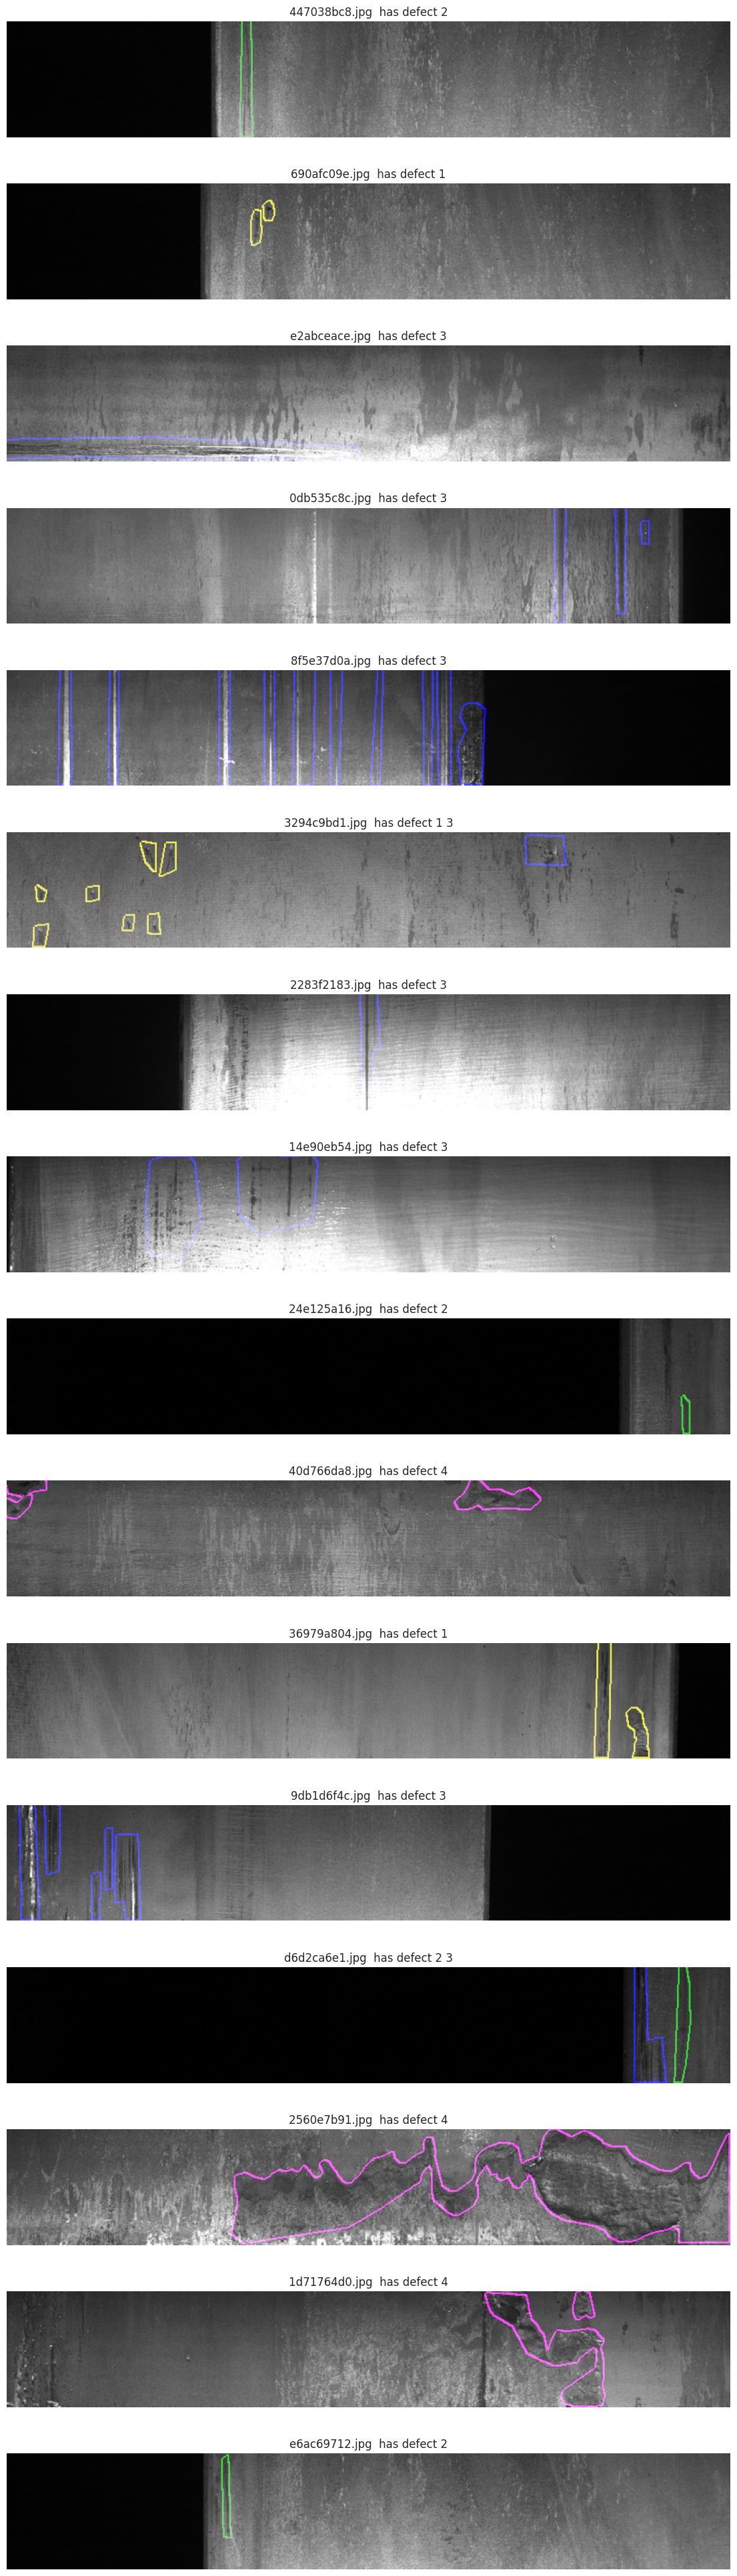

In [10]:
# DEFECTIVE IMAGE SAMPLES
filenames = {}
defects = list(train2[train2['e1']!=''].sample(3).index)
defects += list(train2[train2['e2']!=''].sample(3).index)
defects += list(train2[train2['e3']!=''].sample(7).index)
defects += list(train2[train2['e4']!=''].sample(3).index)

# DATA GENERATOR
train_batches = DataGenerator(train2[train2.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    if i != 0: break
    plt.figure(figsize=(14,50)) #20,18
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

### Define the Complete Model

In [48]:
# start the encoder using the default input size 64 x 84
convs, img_input = FCN8()

# pass the convolutions obtained in the encoder to the decoder
dec_op = fcn8_decoder(convs, G.n_classes)

# define the model specifying the input (batch of images) and output (decoder output)
model = keras.Model(inputs = img_input, outputs = dec_op)
model.summary()

ValueError: Inputs have incompatible shapes. Received shapes (16, 100, 4) and (16, 101, 4)

In [40]:
checkpoint = ModelCheckpoint(
    'model.keras', 
    monitor='val_loss', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers
              .SGD(learning_rate=1e-2, momentum=0.9, nesterov=True), 
              metrics=[dice_coef])

In [41]:
# TRAIN AND VALIDATE MODEL
idx = int(0.8*len(train2)); 

train_batches = DataGenerator(train2.iloc[:idx],shuffle=True)
valid_batches = DataGenerator(train2.iloc[idx:] )
history = model.fit(train_batches,
                    validation_data = valid_batches,
                    callbacks=[checkpoint],
                    epochs = 100)

Epoch 1/100


ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 64, 84, 3), found shape=(None, 128, 800, 3)

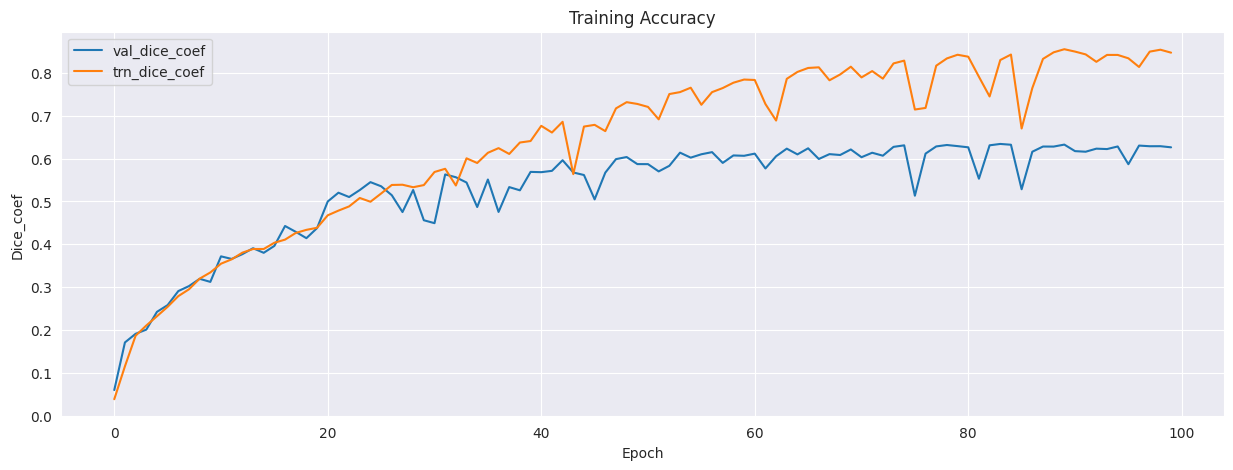

In [14]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()

In [16]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS)
val_set = train2.iloc[idx:]
defects = list(val_set[val_set['e1']!=''].sample(6).index)
defects += list(val_set[val_set['e2']!=''].sample(6).index)
defects += list(val_set[val_set['e3']!=''].sample(14).index)
defects += list(val_set[val_set['e4']!=''].sample(6).index)

valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
preds = model.predict(valid_batches,verbose=1)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


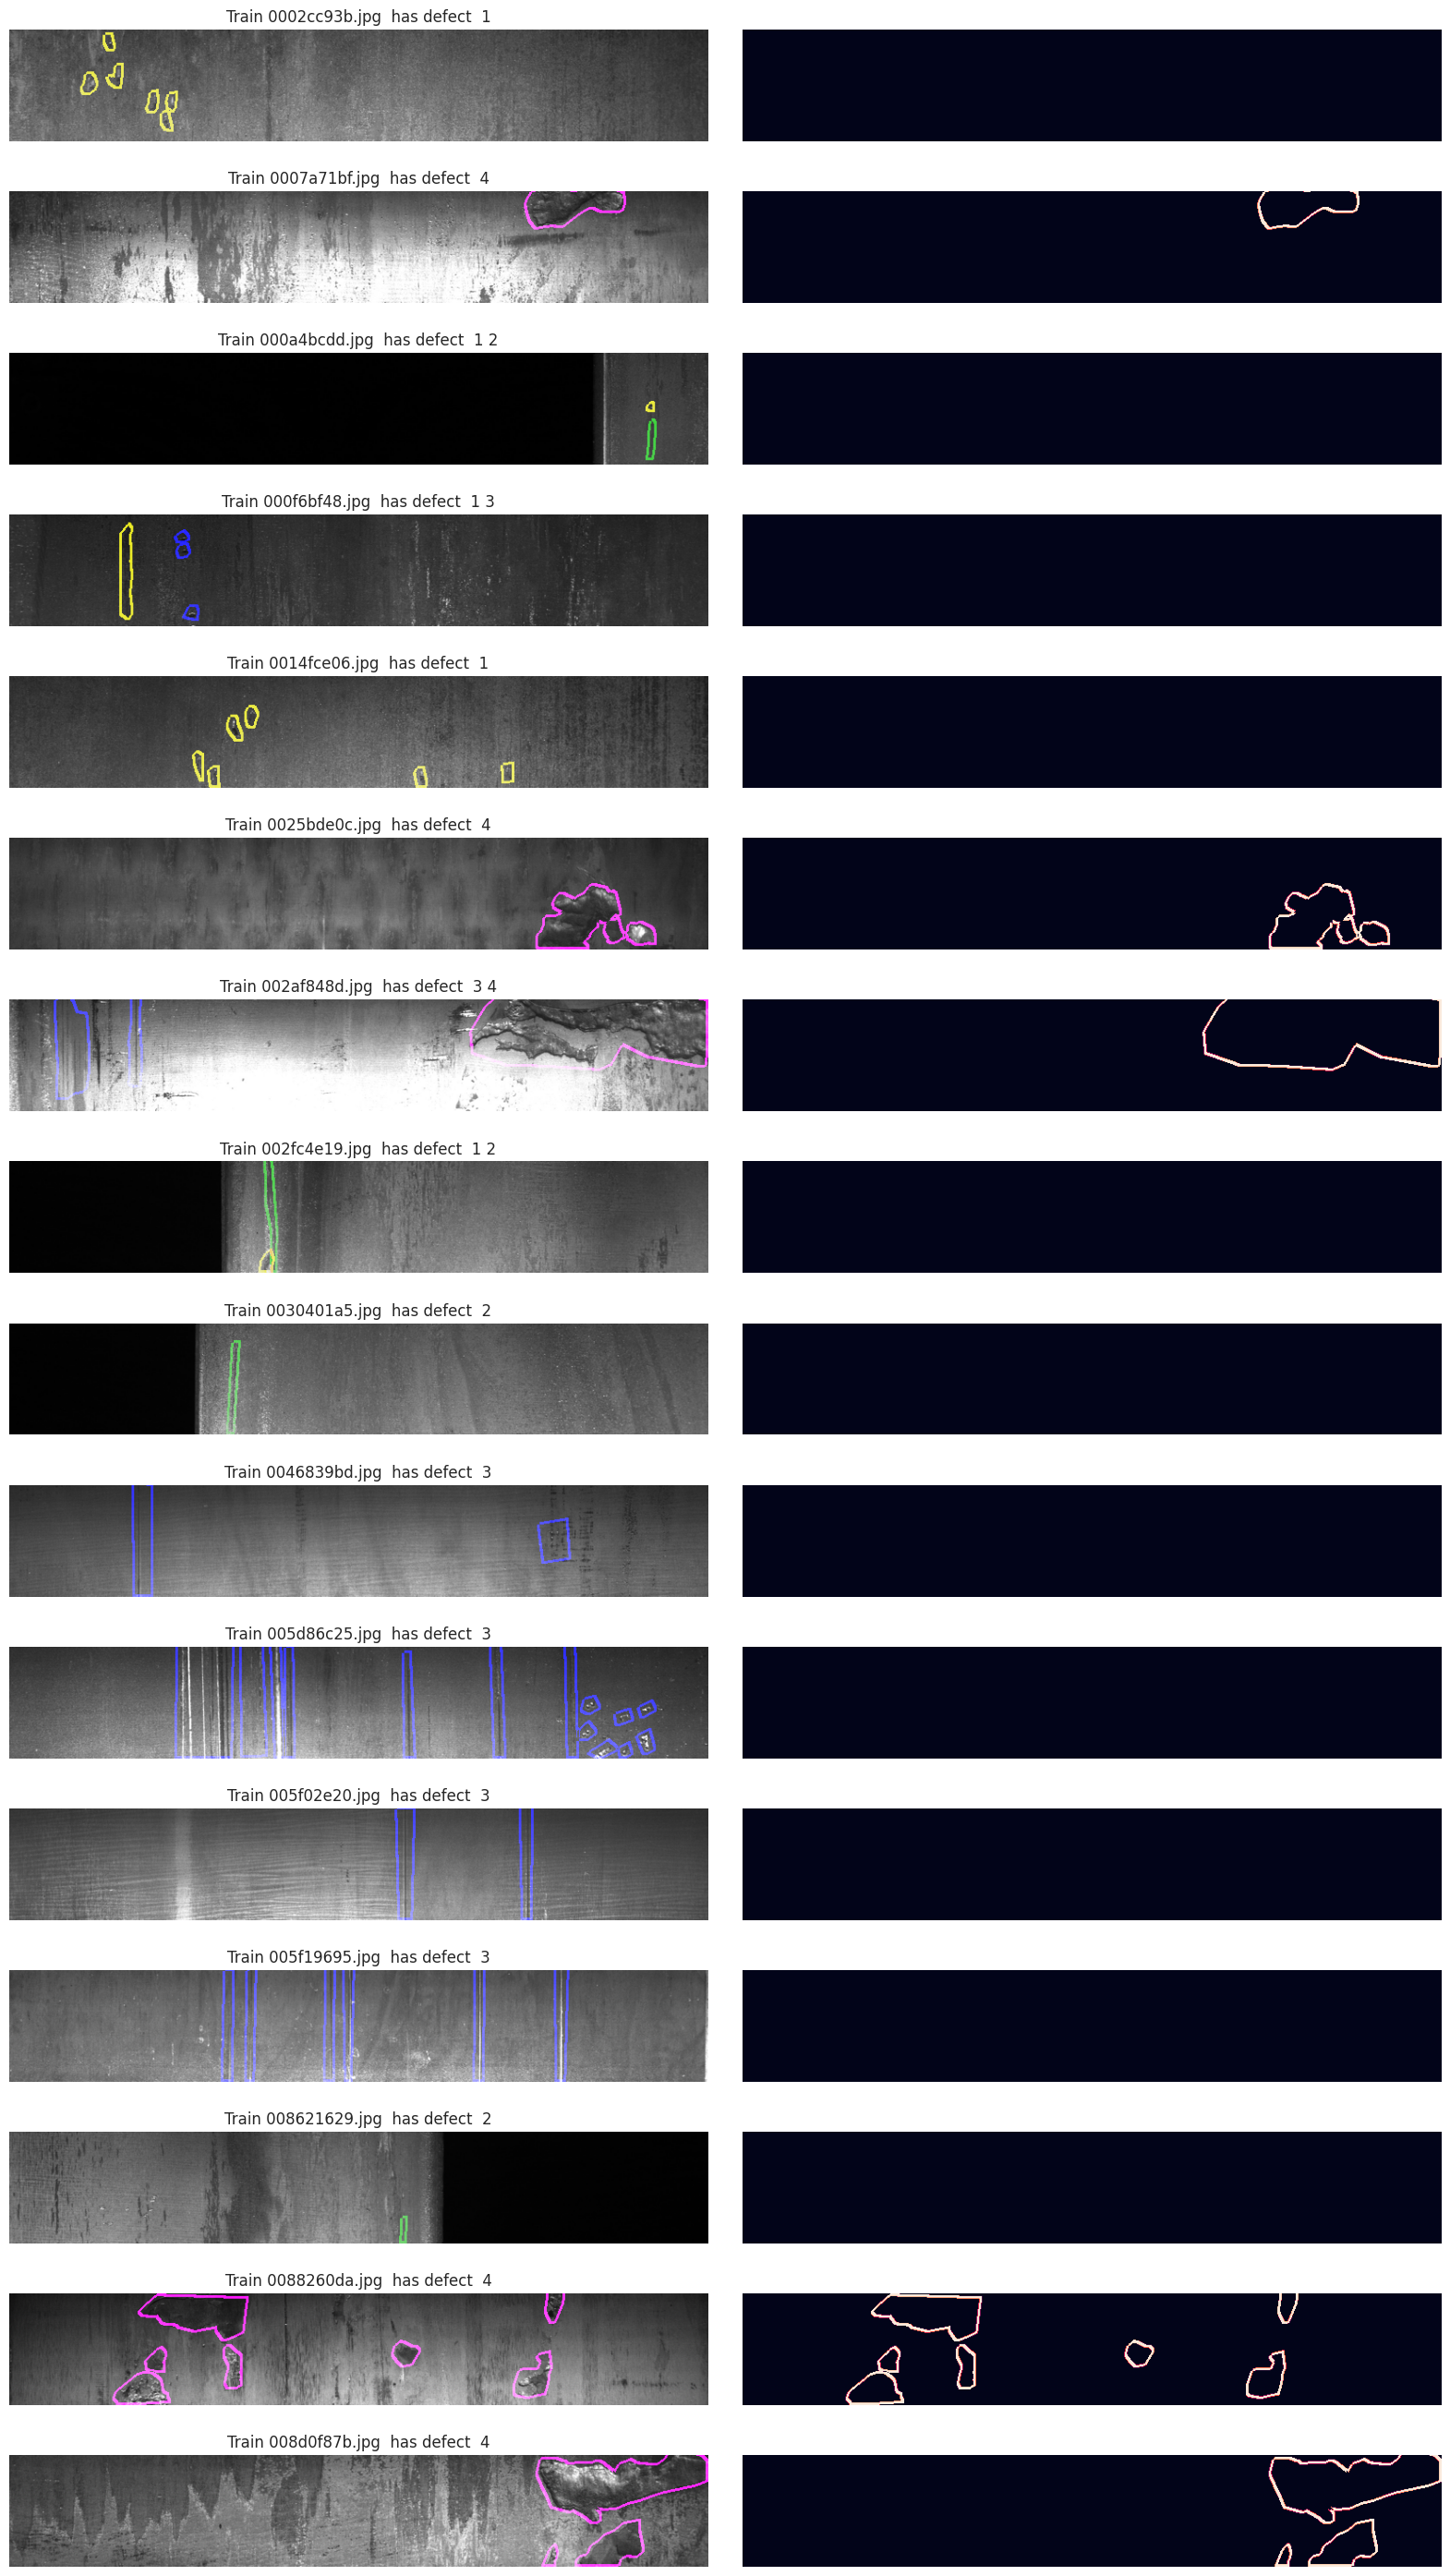

In [17]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i,batch in enumerate(valid_batches):
    if i != 0: break
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        if extra=='  has defect ': extra =''
        plt.title('Train '+train2.iloc[16*i+k,0]+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        if dft!=0:
    #        msk = preds[i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
    #    mx = np.round(np.max(msk),3)
    #    plt.title('Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

### Error EDA 1

In [19]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS 1, 2, 4)
val_set = train2.iloc[idx:]
val_set2 = val_set[(val_set['count']!=0)&(val_set['e3']=='')].sample(16)

valid_batches = DataGenerator(val_set2)
preds = model.predict(valid_batches,verbose=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


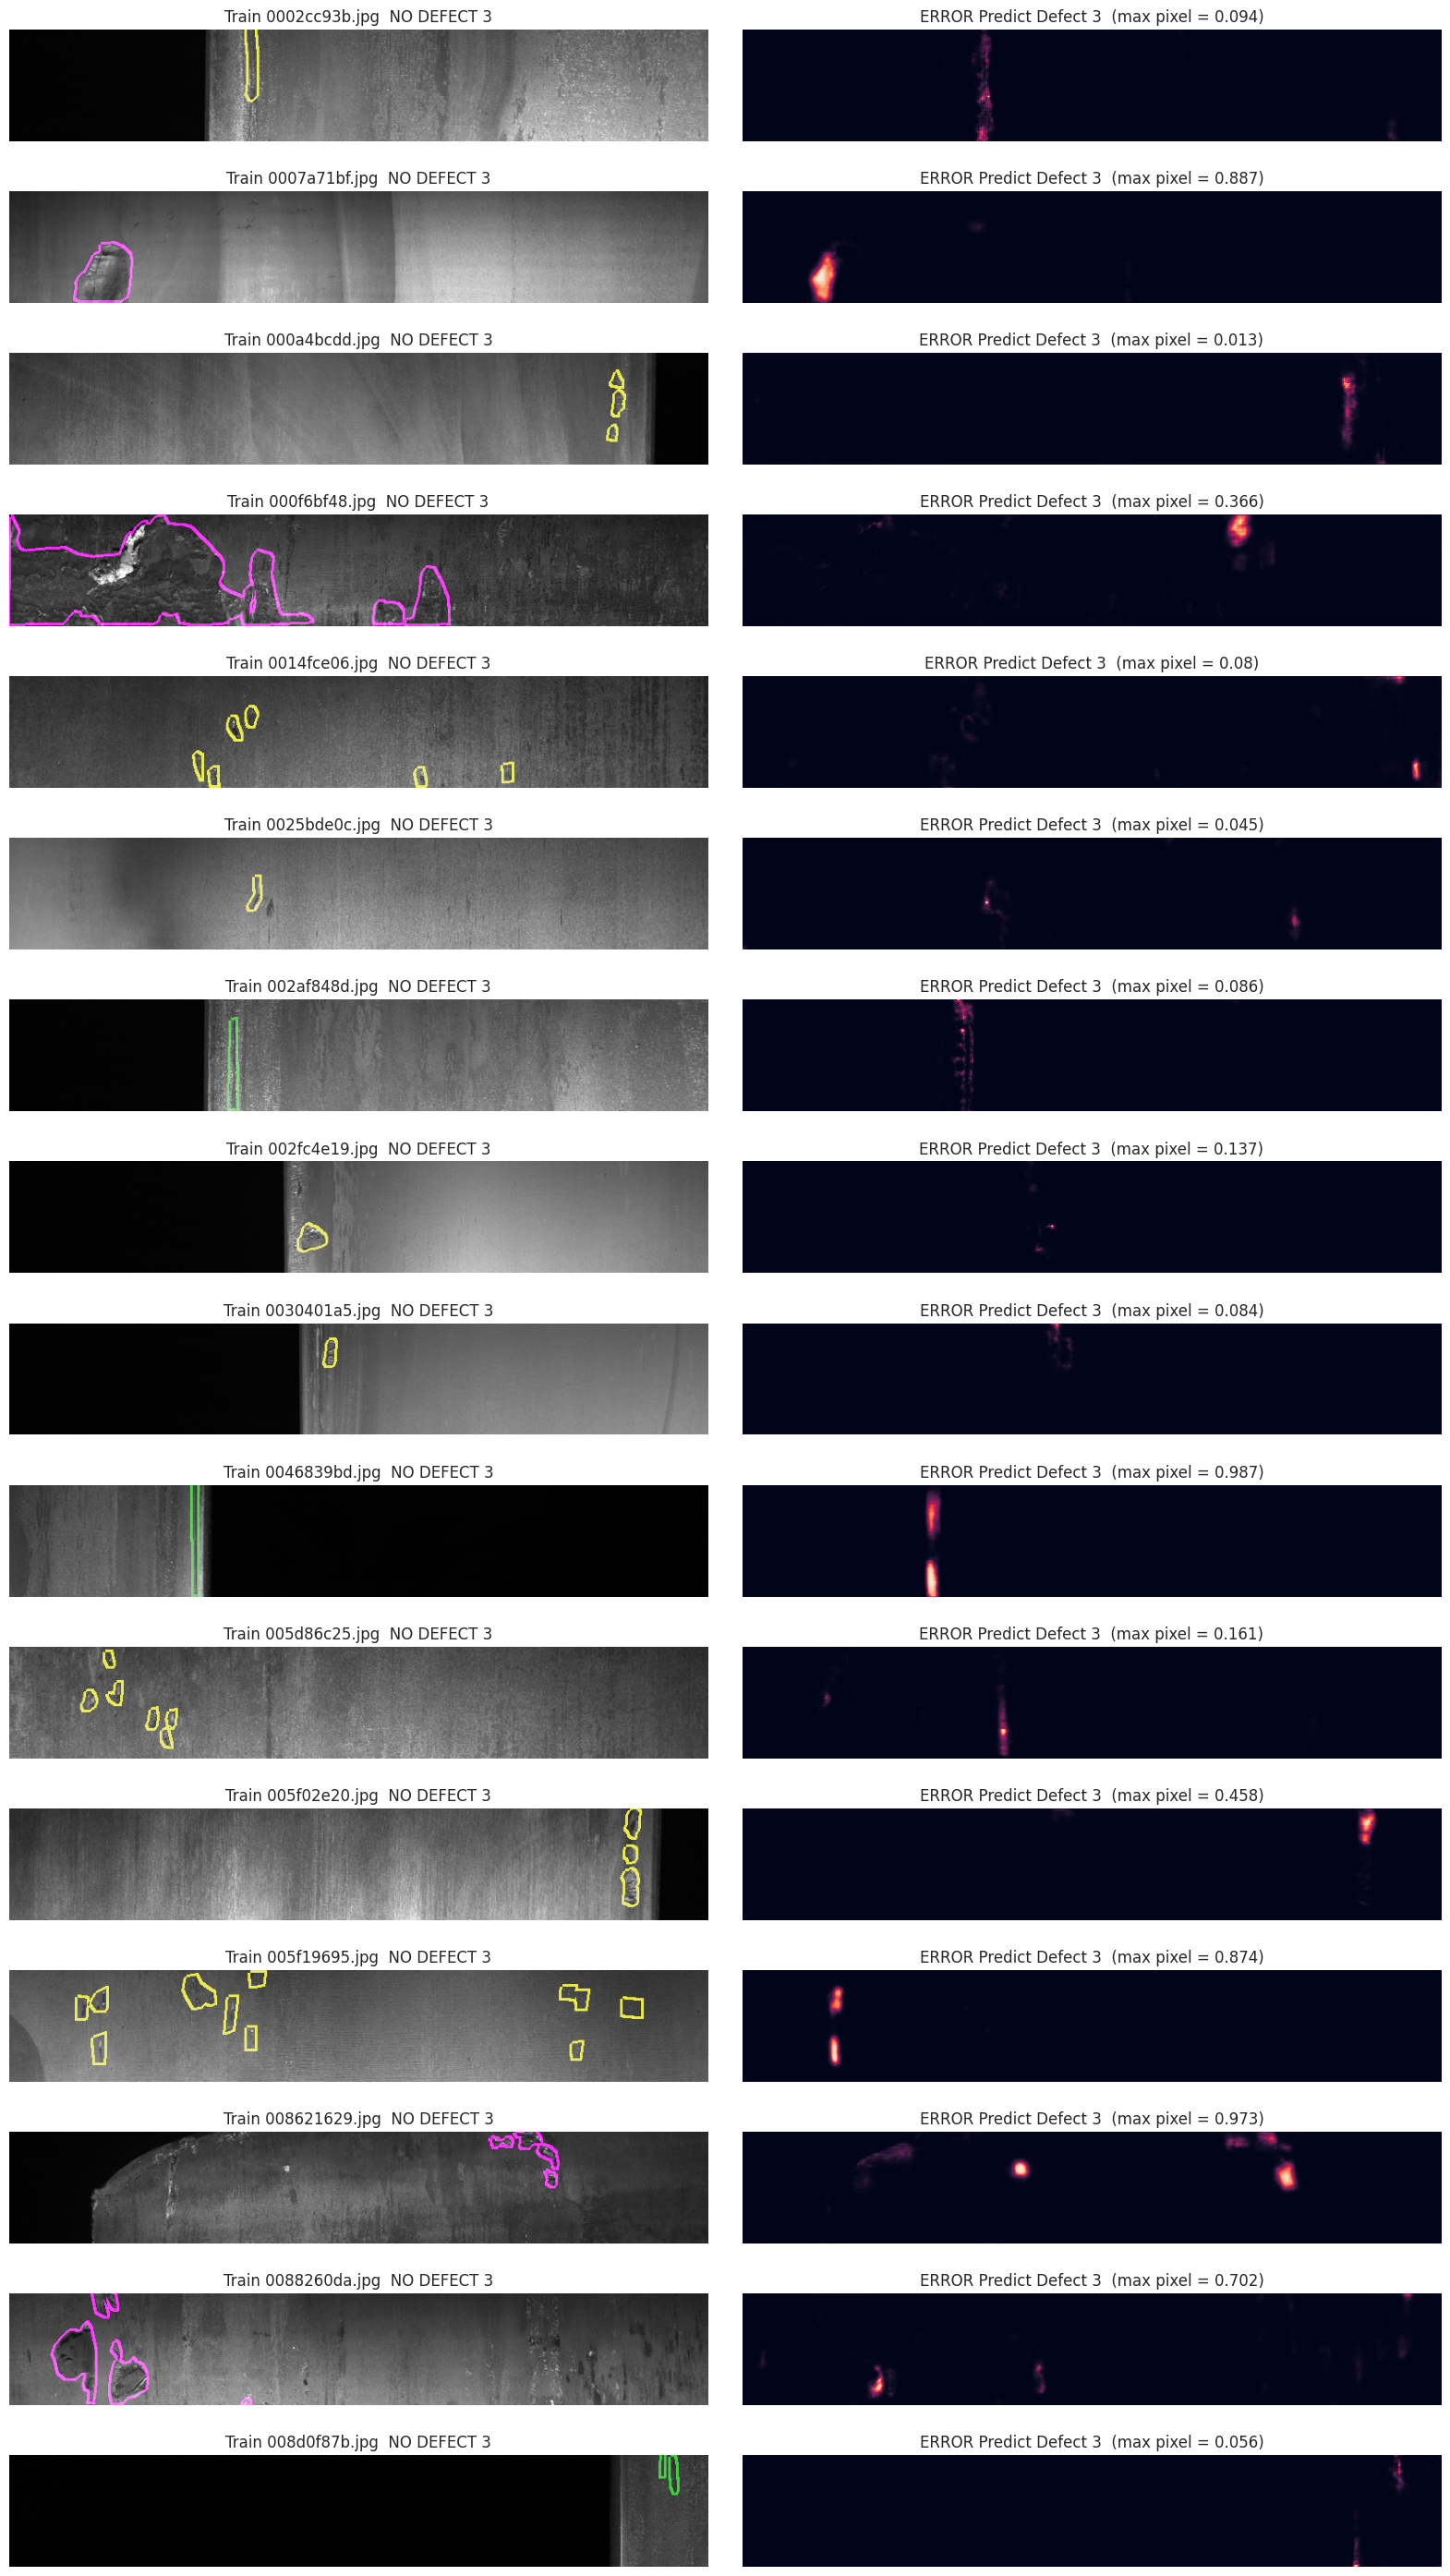

In [20]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set2)
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')
for i,batch in enumerate(valid_batches):
    if i != 0: break
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        three = False
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if (j==2)&(np.sum(msk)!=0): 
                three=np.sum(msk)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        extra = ''; extra2 = ''
        if not three: 
            extra = 'NO DEFECT 3'
            extra2 = 'ERROR '
        plt.title('Train '+train2.iloc[16*i+k,0]+'  '+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        dft=3
        if dft!=0:
            msk = preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title(extra2+'Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

<Axes: >

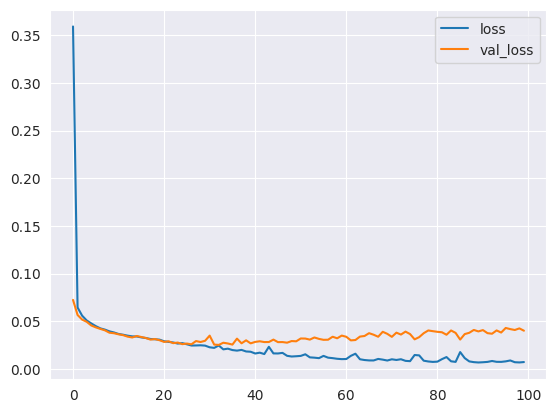

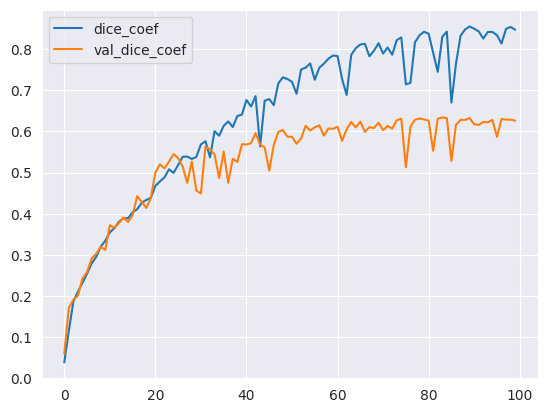

In [21]:
import json
with open('history.json', 'w') as f:
    json.dump(history.history, f)

history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['dice_coef', 'val_dice_coef']].plot()